In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os
from time import time, sleep
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

from utils import generate_run_id, get_input_args, Args, parse_run_id
from models import Discriminator_FC, Generator_MNIST, Weight_Clipper, G_weights_init, Generator_FC, Decoder_Mini, VAE, Encoder_VAE, Decoder_VAE
from data import load_MNIST
from metrics import get_IS, get_FID
from model_inversion import enc_fp, dec_fp, gen_fp
from evaluate_metrics import last_num_models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
pub_G = Generator_FC(hidden_sizes=[256], nz=100).to(device)
pub_G.load_state_dict(torch.load(gen_fp))
pub_G.eval()

pub_Dec = Decoder_Mini(latent_size=100).to(device)
pub_Dec.load_state_dict(torch.load(dec_fp))

<All keys matched successfully>

In [80]:
def generate_samples(G, args, latent_type=None, plot=True, batch_size=32, seed=False):
    if seed:
        torch.manual_seed(42)

    # Generate Sample Images
    noise = torch.randn(batch_size, args.nz).to(device)
    
    if latent_type == "wgan":
        output = G(noise)
        fake = pub_G(output)
    elif latent_type == "ae":
        output = G(noise)
        fake = pub_Dec(output)
    else:
        fake = G(noise)
    
    fake = fake.view(fake.size(0), 1, 28, 28)

    if plot:
        # Plot Sample Images
        fig, ax = plt.subplots(4, 8, figsize=(10, 5))
        for i in range(4):
            for j in range(8):
                ax[i, j].imshow(fake[i*8+j][0].detach().cpu().numpy(), cmap='gray')
                ax[i, j].axis('off')
        plt.show()
        # Close Figure
        plt.close()
    
    return fake

In [81]:
def samples_during_training(run_fp, end=50000, step=5000):
    # Parse args
    run_id = run_fp.split("/")[-1]
    args = parse_run_id(run_id)

    imgs = []
    for j in range(step, end + 1, step):
        gen_fp = f"vae_{j}.pt"
        gen_fp = os.path.join(run_fp, gen_fp)

        # Check if model exists
        if not os.path.exists(gen_fp):
            print("Model does not exist", gen_fp)
            raise ValueError("Model does not exist")

        vae = VAE(
            Encoder_VAE(args.hidden, latent_size=args.nz), 
            Decoder_VAE(args.hidden, latent_size=args.nz)
        ).to(device)
        vae.load_state_dict(torch.load(gen_fp))
        vae.eval()

        G = vae.decoder
        G.eval()

        fake = generate_samples(
            G, args, latent_type="wgan" if run_id.startswith("wgan") else "ae", 
            plot=False, batch_size=10, seed=True
        )
        imgs.append(fake)
    
    # Plot Sample Images
    # Label each column with the epoch
    n = len(imgs)
    fig, ax = plt.subplots(10, n)
    for i in range(10):
        for j in range(n):
            ax[i, j].imshow(imgs[j][i][0].detach().cpu().numpy(), cmap='gray')
            ax[i, j].axis('off')
            if i == 0:
                ax[i, j].set_title(f"{(j+1)*step}", color="white", fontsize=9)
    # No space in between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    # Background color
    fig.patch.set_facecolor('black')

    # Set title
    fig.suptitle(f"Samples during training epochs", color="white", fontsize=12)

    plt.show()

ae-grad_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0


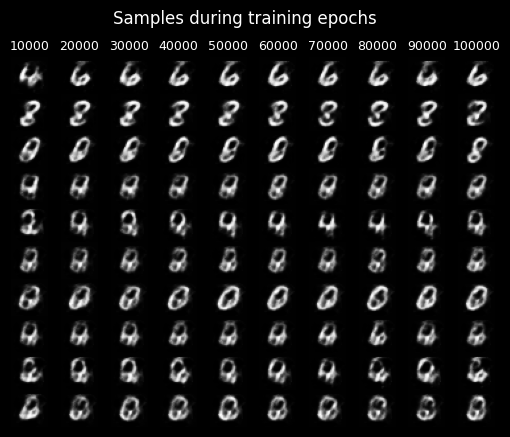

In [82]:
run_folder = "runs_vae"
run_id = "ae-grad_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0"

run_fp = os.path.join(run_folder, run_id)
print(run_id)

samples_during_training(run_fp, end=100000, step=10000)

ae-grad_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0vae_38200.pt
tensor(2.1996e-07, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9822, device='cuda:0', grad_fn=<MaxBackward1>)


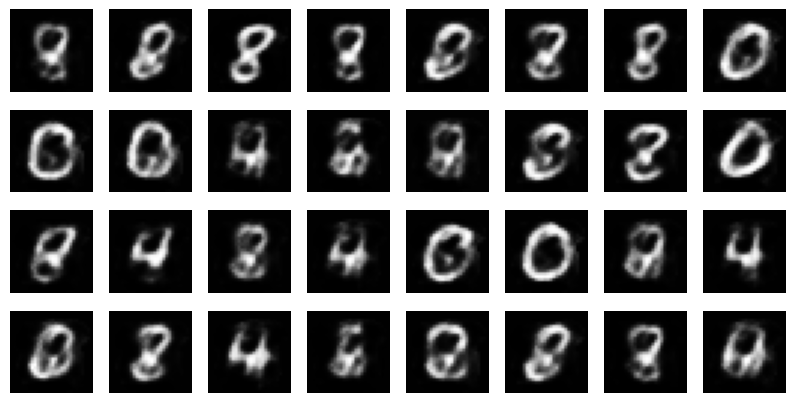

ae-enc_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0vae_100000.pt
tensor(1.0149e-07, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9862, device='cuda:0', grad_fn=<MaxBackward1>)


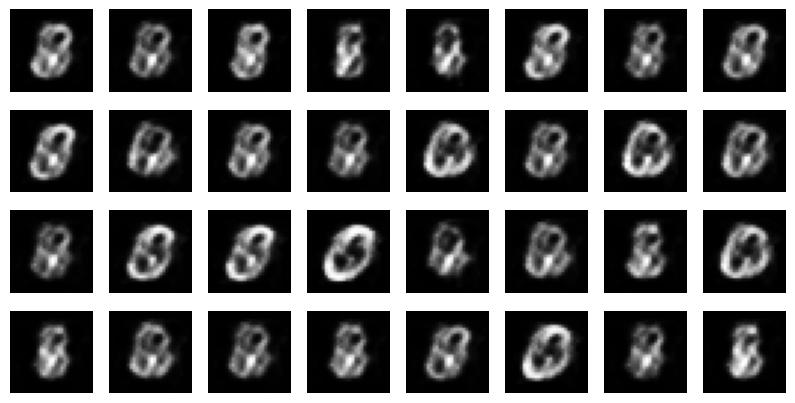

In [49]:
run_folder = "runs_vae"
run_ids = os.listdir(run_folder)
for i in range(len(run_ids)):
    run_id = run_ids[i]
    run_fp = os.path.join(run_folder, run_id)
    args = parse_run_id(run_id)

    # if args.lr != 0.1:
    #     continue
    # if args.n_g != 50000:
    #     continue
    c_ps = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
    if args.c_p > 32.0:
        continue
    # if args.c_p not in c_ps:
    #     continue

    gen_fp = last_num_models(run_fp, num=1, query="vae")[0]
    print(run_id + gen_fp)

    gen_fp = os.path.join(run_fp, gen_fp)

    # Check if exists
    if not os.path.exists(gen_fp):
        print("Generator model not found")
        continue
    
    vae = VAE(
        Encoder_VAE(args.hidden, latent_size=args.nz), 
        Decoder_VAE(args.hidden, latent_size=args.nz)
    ).to(device)
    vae.load_state_dict(torch.load(gen_fp))
    vae.eval()

    G = vae.decoder
    G.eval()

    generate_samples(G, args, latent_type="wgan" if run_id.startswith("wgan") else "ae")

In [ ]:
# run_id = "/home/jason/p2/runs_latent/wgan_96_64_32_1_50.0_1e-06_0.0_0.01_5e-05_0.5_64_1_50000_LeakyReLU_0.0"
run_ids = os.listdir("runs_latent")
for i in range(len(run_ids)):
    # run_ids[i] = os.path.join("runs_latent", run_ids[i])
    run_id = run_ids[i]
    print(run_id)

    run_id = run_id.split("/")[-1]
    run_fp = os.path.join('runs_latent/', run_id)
    args = parse_run_id(run_id)

    gen_fp = os.path.join(run_fp, 'netG_48000.pt')
    # Check if exists
    if not os.path.exists(gen_fp):
        print("Generator model not found")
        continue

    G = Generator_FC(args.hidden, args.nz, output_size=(100,)).to(device)
    G.load_state_dict(torch.load(gen_fp))
    G.eval()

    generate_samples(G, args, latent_type="wgan" if run_id.startswith("wgan") else "ae")

In [ ]:
# Calculate Epsilons

In [88]:
# Generating samples from gradient ascent
labeling_loader, public_loader, private_loader, test_loader = load_MNIST(10)

# Get a single batch of private images
imgs, _ = next(iter(private_loader))
imgs.shape

Loading MNIST splits from disk


torch.Size([10, 1, 28, 28])

In [83]:
def run_wgan(gen_fp, train_loader, save_fp="data/wgan_latent_dataset.pt"):
    """Iterates through all images in train_loader and performs 
        gradient ascent on each image
    """
    # Load model
    model = Generator_FC(hidden_sizes=[256], nz=100).to(device)
    model.load_state_dict(torch.load(gen_fp))

    # Initialize new latent dataset
    latent_dataset = data.TensorDataset(torch.zeros(0, 100).to(device))

    # Get images
    for imgs, _ in tqdm(train_loader):
        imgs = imgs.to(device)

        # Perform gradient ascent
        latent_vectors = projected_gradient_ascent(
            model, imgs, latent_dim=100, start_lr=200,
            iterations=200000, z_0_mult=1)
        
        # Save latent vectors to torch dataset
        latent_dataset = data.TensorDataset(torch.cat((latent_dataset.tensors[0], latent_vectors), dim=0))

    # Save latent vectors to file
    torch.save(latent_dataset, save_fp)
    print(f"Saved {latent_dataset.tensors[0].shape[0]} latent vectors")


def run_ae_grad(dec_fp, train_loader, save_fp="data/ae_grad_latent_dataset.pt"):
    """Iterates through all images in train_loader and performs 
        gradient ascent on each image
    """
    # Load model
    decoder = Decoder_Mini(latent_size=100).to(device)
    decoder.load_state_dict(torch.load(dec_fp))

    # Initialize new latent dataset
    latent_dataset = data.TensorDataset(torch.zeros(0, 100).to(device))

    # Get images
    for imgs, _ in tqdm(train_loader):
        imgs = imgs.to(device)

        # Perform gradient ascent
        latent_vectors = gradient_ascent(
            decoder, imgs, latent_dim=100, start_lr=200,
            iterations=200000)
        
        # Save latent vectors to torch dataset
        latent_dataset = data.TensorDataset(torch.cat((latent_dataset.tensors[0], latent_vectors), dim=0))

    # Save latent vectors to file
    torch.save(latent_dataset, save_fp)
    print(f"Saved {latent_dataset.tensors[0].shape[0]} latent vectors")


def run_ae(enc_fp, train_loader, save_fp="data/ae_enc_latent_dataset.pt"):
    """Iterates through all images in train_loader and encodes each image
    """
    # Load model
    encoder = Encoder_Mini(latent_size=100).to(device)
    encoder.load_state_dict(torch.load(enc_fp))

    # Initialize new latent dataset
    latent_dataset = data.TensorDataset(torch.zeros(0, 100).to(device))

    # Get images
    for imgs, _ in tqdm(train_loader):
        imgs = imgs.to(device)

        # Encode images
        latent_vectors = encoder(imgs)
        
        # Save latent vectors to torch dataset
        latent_dataset = data.TensorDataset(torch.cat((latent_dataset.tensors[0], latent_vectors), dim=0))

    # Save latent vectors to file
    torch.save(latent_dataset, save_fp)
    print(f"Saved {latent_dataset.tensors[0].shape[0]} latent vectors")

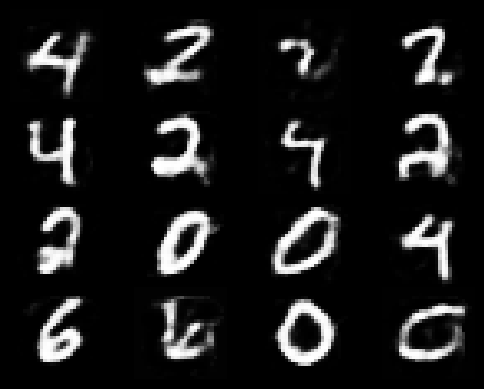

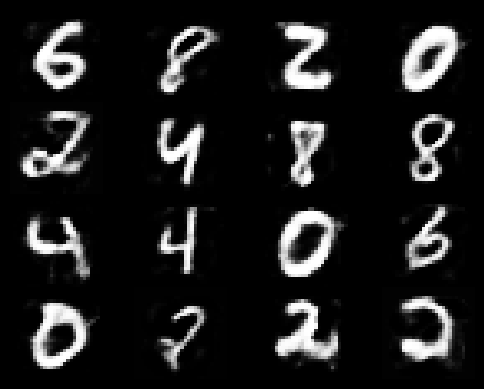

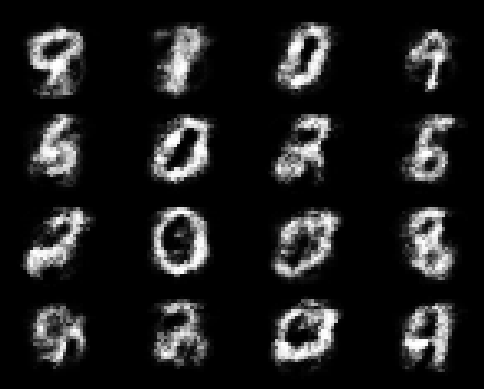

In [76]:
from data import load_latent
# Seed
torch.manual_seed(0)

# Load Latent Vectors
loader_ae_enc = load_latent(16, data_fp="data/ae_enc_latent_dataset.pt")
loader_ae_grad = load_latent(16, data_fp="data/ae_grad_latent_dataset.pt")
loader_wgan = load_latent(16, data_fp="data/wgan_latent_dataset.pt")

# Grab a single batch
batch_ae_enc = next(iter(loader_ae_enc))[0]
batch_ae_grad = next(iter(loader_ae_grad))[0]
batch_wgan = next(iter(loader_wgan))[0]

# Latent space to image space
images_ae_enc = pub_Dec(batch_ae_enc)
images_ae_grad = pub_Dec(batch_ae_grad)
images_wgan = pub_G(batch_wgan)

# Plot all images of a batch
def plot_batch(images):
    fig, ax = plt.subplots(4, 4)
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(images[i*4 + j][0].detach().cpu().numpy(), cmap='gray')
            ax[i, j].axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.patch.set_facecolor('black')

    plt.show()

plot_batch(images_ae_enc)
plot_batch(images_ae_grad)
plot_batch(images_wgan)



torch.Size([4, 100])
tensor(-0.6163, device='cuda:0', grad_fn=<MeanBackward0>)


IndexError: index 4 is out of bounds for dimension 0 with size 4

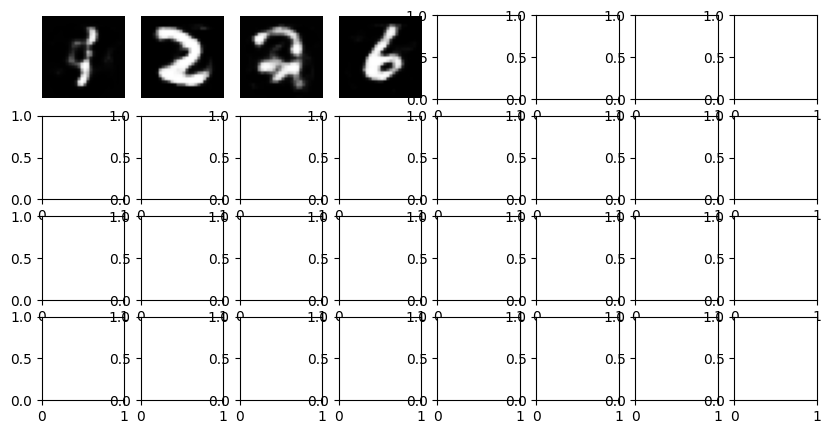

In [72]:


for i, (data, ) in enumerate(train_loader):
    # Print difference between item 0 and 1
    print(data.shape)
    print(torch.mean(data[0] - data[1]))

    # Add noise to data
    data = data + torch.randn_like(data)
    
    # Decode
    fake = pub_Dec(data)
    fake = fake.view(fake.size(0), 1, 28, 28)

    # Plot Sample Images
    fig, ax = plt.subplots(4, 8, figsize=(10, 5))
    for i in range(4):
        for j in range(8):
            ax[i, j].imshow(fake[i*8+j][0].detach().cpu().numpy(), cmap='gray')
            ax[i, j].axis('off')

    plt.show()
    break

In [ ]:
# Load the generator
# run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.0_0.01_0.0001_0.5_64_5_200000_LeakyReLU" # decent
run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_500000_LeakyReLU" # better
run_id = "/home/jason/p2/runs/16-12_100_32_1_38.0_1e-06_0.05_0.01_0.0001_0.5_64_5_200000_LeakyReLU" # somewhat reasonable noised
run_id = "/home/jason/p2/runs_gen_fc_3/public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0"
run_id = "/home/jason/p2/runs_gen_fc_3/public_256_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0"

run_id = run_id.split("/")[-1]
run_fp = os.path.join('runs_gen_fc_3/', run_id)
args = parse_run_id(run_id)

for i in range(500000, 500000 + 1, 10000):
    gen_fp = os.path.join(run_fp, 'netG_{}.pt'.format(i))
    if os.path.exists(gen_fp):
        print("Loading {}".format(gen_fp))

        G = Generator_FC([256], args.nz).to(device)
        G.load_state_dict(torch.load(gen_fp))
        G.eval()

        generate_samples(G, args)

In [ ]:
# Random Seeding
torch.manual_seed(0)
np.random.seed(0)


activation = 'LeakyReLU'
args = Args(
    # Model Parameters
    hidden=[16, 12], nz=100, ngf=32, nc=1, activation=activation,
    # Privacy Parameters
    epsilon=50.0, delta=1e-6, noise_multiplier=0.3, c_p=0.01, 
    # Training Parameters
    lr=1e-3, beta1=0.5, batch_size=16, n_d=3, n_g=int(1e4), lambda_gp=10.0,
)

# Generate Run ID
run_id = generate_run_id(args)


run_id = "public_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_300000_LeakyReLU"
# run_id = "16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000"
# /home/jason/p2/runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_64_4_300000_Tanh"
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_64_5_300000_Tanh"
run_id = "16-12_100_32_1_50.0_1e-06_0.2_0.005_0.0001_0.5_64_4_300000_Tanh"

# Create Folder Path
run_fp = os.path.join('runs/', run_id)
run_fp

In [ ]:
fps = os.listdir("runs_gen_fc/")
len(fps)

In [ ]:
args
# 3,4,6*,8,9,10*,13*,16,19,20
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)

In [ ]:
# bad
args
# 0,1,2,5,7,11,12,14,15,17,18,21
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)

In [ ]:
idx = 12
fp = os.path.join("runs_gen_fc/", fps[idx])
args = parse_run_id(fps[idx])

for i in range(0, 100000 + 1, 20000):
    gen_fp = os.path.join(fp, 'netG_{}.pt'.format(i))
    if os.path.exists(gen_fp):
        print("Loading {}".format(gen_fp))
        
        G = Generator_FC([128], args.nz).to(device)
        G.load_state_dict(torch.load(gen_fp))
        G.eval()

        generate_samples(G, args)

In [ ]:
def plot_loss(run_fp):
    # Read loss.txt
    loss_fp = os.path.join(run_fp, 'loss.txt')
    epsilons = []
    d_loss, g_loss = [], []

    with open(loss_fp, 'r') as f:
        loss = f.read().splitlines()
        for i in range(len(loss)):
            if "time" in loss[i]:
                continue
            idx, l = loss[i].split(", ")

            if "." in idx:
                # Discriminator_FC Loss
                idx = int(float(idx))
                d_loss.append((idx, float(l)))
            else:
                # Generator Loss
                idx = int(float(idx))
                g_loss.append((idx, float(l)))

    # Graph Loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator_FC Loss During Training")
    plt.plot(*zip(*d_loss), label="Discriminator_FC")
    plt.plot(*zip(*g_loss), label="Generator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")

    # Only show first 100 epochs
    # plt.xlim(-10, 20000)
    plt.legend()
    plt.show()

In [ ]:
G

In [ ]:
# Generate 2048 fake images
noise = torch.randn(2048, 100).to(device)
fake = G(noise)
fake = fake.view(fake.size(0), 1, 28, 28)

In [ ]:
# Calculate Inception Score
IS = get_IS(fake)
print("Inception Score:", IS)

# Calculate Frechet Inception Distance
FID = get_FID(fake)
print("Frechet Inception Distance:", FID)